# Examples Chaining search
This notebook contains a number of examples of chaining linguistic resources: corpora, lexica and treebanks. Try the examples, or copy the code and customize the examples in the [Sandbox](Sandbox.ipynb).


## List of examples
### Corpora
 * [Corpus search](#corpus-search)
 * [Frequency of *zeker*+verb and *vast*+verb compared](#freq-puur-zuiver)
 * [Train a POS tagger on an annotated corpus](#pos-tagger)
 * [Search in corpus and filter on metadata](#corpus-filter-metadata)
 * [Visualizing h-dropping](#visualizing-h-dropping)
 * [Generate lexicon from several corpora](#lexicon-several-corpora)

### Lexica
 * [Lexicon search](#lexicon-search)

### Corpus + lexicon
 * [Retrieve synonyms from DiaMaNT, look up in Gysseling](#synonyms-diamant-gysseling)
 * [Build a frequency list of the lemma of some corpus output](#freq-lemma-corpus)
 * [Find occurences of attributive adjectives not ending with -e, even though they are preceeded by a definite article](#adjective-e)
 * [Look up inflected forms and spelling variants for a given word form in a corpus](#inflected-spelling-corpus)
 * [Corpus frequency list of word forms from lexicon with given lemma](#corpus-frequency-lemma-pos)
 * [Build a frequency table of some corpus, based on word forms list of a given lexicon](#freqtable-lemmalist)
 * [Search corpus for wordforms of lemma not included in lexicon](#corpus-wordforms-not-lexicon)
 
### Treebanks
 * [Treebank search](#treebank-search)
 * [Which objects of verb *geven* occur?](#treebank-objects-geven)
 ---

## Corpus

### Corpus search <a class="anchor" id="corpus-search"></a>

* Run the cell below to show the UI, and fill in your search query

In [ ]:
from chaininglib.ui.search import create_corpus_ui

# Create corpus UI, creates references to field contents
corpusQueryField, corpusField = create_corpus_ui()


 * Click the cell below and press Run to perform the given query

In [ ]:
from chaininglib.search.CorpusQuery import *
from chaininglib.ui.dfui import display_df

#from chaininglib import search
query= corpusQueryField.value
corpus_name = corpusField.value
df_corpus = create_corpus(corpus_name).pattern(query).search().kwic()
#df_corpus = load_dataframe('mijn_resultaten.csv')
display_df(df_corpus, labels="Results")



### Frequency of *zeker*+verb and *vast*+verb compared <a class="anchor" id="freq-puur-zuiver"></a>
* Below cell searches for *zeker*+verb and for *vast*+verb in the Letters as Loot (zeebrieven) corpus
* Compare frequencies

In [ ]:
#from chaininglib import search
from IPython.core.display import display, HTML
from chaininglib.search.CorpusQuery import *
from chaininglib.ui.dfui import display_df
from chaininglib.utils.dfops import column_difference

corpus_name = "zeebrieven"

# Word 1: puur
word1= "zeker"
cq1 = create_corpus(corpus_name).pattern(r'[lemma="' + word1 + r'"][pos="VRB.*"]')
df_corpus1 = cq1.search().kwic()
display_df(df_corpus1, word1)

# Word 2: zuiver
word2 = "vast"
cq2 = create_corpus(corpus_name).pattern(r'[lemma="' + word2 + r'"][pos="VRB.*"]')
df_corpus2 = cq2.search().kwic()
display_df(df_corpus2, word2)

# Compute difference
diff_left, diff_right, intersec = column_difference(df_corpus1["word 1"], df_corpus2["word 1"])
# Elements of 1 that are not in 2
display(HTML('Werkwoorden voor <b>' + word1 + '</b> niet in <b>' + word2 + '</b>: ' + ", ".join(diff_left)))
# Elements of 2 that are not in 1
display(HTML('Werkwoorden voor <b>' + word2 + '</b> niet in <b>' + word1 + '</b>: ' + ", ".join(diff_right)))
# Elements both in 1 and 2
display(HTML('Werkwoorden zowel voor <b>' + word1 + '</b> als voor <b>' + word2 + '</b>: ' + ", ".join(intersec)))

### Train a POS tagger on an annotated corpus <a class="anchor" id="pos-tagger"></a>

In [ ]:
from chaininglib.ui.dfui import display_df
from chaininglib.process.corpus import get_tagger
from chaininglib.search.CorpusQuery import *
from chaininglib.search.LexiconQuery import *

import pandas as pd

# TODO: replace by historical lexicon
base_lexicon="molex"

# we have a given word
some_word = "lopen"

# get the paradigm of the lemma our word is a part of
l = create_lexicon(base_lexicon).lemma(some_word).search()
df_paradigm = l.kwic()
display_df(df_paradigm)

# gather some pattern including our word, out of annotated corpora
# here: DET + ADJ + 'loop'

dfs_all_corpora = []

for one_corpus in get_available_corpora():
    print('querying '+one_corpus+'...')
    c = create_corpus(one_corpus).word(some_word).detailed_context(True).search()
    df_corpus = c.kwic() 
    
    # store the results
    dfs_all_corpora.append(df_corpus)


# get a tagger trained with our corpus data
tagger = get_tagger(dfs_all_corpora, pos_key = 'pos') 

# Use the trained tagger to tag unknown sentences
# The input must be like: tagger.tag(['today','is','a','beautiful','day'])

sentence = 'Zij lopen graag in het bos als het mooi weer is'
tagged_sentence = tagger.tag( sentence.split() )

print(tagged_sentence)


# Know we can lemmatize each occurence of our lemma in the new sentences

### Search in corpus and filter on metadata <a class="anchor" id="corpus-filter-metadata"></a>
First, we request all available metadata fields of the corpus. Then, we issue a search query, and request all metadata fields for the result. Finally, we filter on metadata values.

In [ ]:
from chaininglib.search.metadata import get_available_metadata
from chaininglib.utils.dfops import df_filter, property_freq
from chaininglib.ui.dfui import display_df
from chaininglib.search.CorpusQuery import *


corpus_name="zeebrieven"
query=r'[lemma="boek"]'
# Request all metadata fields from corpus
fields = get_available_metadata(corpus_name)
# Perform query and ask all metadata
c = create_corpus(corpus_name).pattern(query).extra_fields_doc(fields["document"]).search()
df_corpus = c.kwic()

# Filter on year: > 1700
df_filter_year = df_corpus[df_corpus["witnessYear_from"].astype('int32') > 1700] 
display_df(df_filter_year, labels="After 1700")

# Filter on sender birth place Amsterdam
condition = df_filter(df_corpus["afz_geb_plaats"], pattern="Amsterdam")
df_filter_place = df_corpus[ condition ]
display_df(df_filter_place, labels="Sender born in Amsterdam")


# Group by birth place
df = property_freq(df_corpus,"afz_loc_plaats")
display_df(df, labels="Most frequent sender locations")

### Visualizing h-dropping  <a class="anchor" id="visualizing-h-dropping"></a>

In [ ]:

from chaininglib.search.CorpusQuery import *
from chaininglib.search.metadata import get_available_metadata
from chaininglib.ui.dfui import display_df
 
corpus_to_search="zeebrieven"
group_by_column = 'afz_geb_plaats'
 
fields = get_available_metadata(corpus_to_search)
 
df_corpus1 = create_corpus(corpus_to_search).pattern(r'[lemma="h[aeo].*" & word="[aeo].*"]').extra_fields_doc(fields["document"]).search().kwic()
df_corpus2 = create_corpus(corpus_to_search).pattern(r'[lemma="h[aeo].*" & word="h[aeo].*"]').extra_fields_doc(fields["document"]).search().kwic()
 
#display_df( df_corpus1)
#display_df( df_corpus2)
 
display_df( df_corpus1[['lemma 0', group_by_column]].groupby(group_by_column).count().sort_values(ascending=False,by=['lemma 0']).head(25), labels="h-dropping", mode='chart')
display_df( df_corpus2[['lemma 0', group_by_column]].groupby(group_by_column).count().sort_values(ascending=False,by=['lemma 0']).head(25), labels="normal", mode='chart')


### Generate lexicon from several corpora <a class="anchor" id="lexicon-several-corpora"></a>

In [6]:
from chaininglib.ui.dfui import display_df
from chaininglib.process.corpus import extract_lexicon
from chaininglib.search.CorpusQuery import *

dfs_all_corpora = []
for one_corpus in get_available_corpora(exclude=["nederlab"]):
    print('querying '+one_corpus+'...')
    c = create_corpus(one_corpus).pos("NOU").detailed_context(True).search()
    df_corpus = c.kwic() 
    # store the results
    dfs_all_corpora.append(df_corpus)

    
# extract lexicon and show the result
extracted_lexicon = extract_lexicon(dfs_all_corpora, posColumnName="pos") # For FCS: posColumnName=universal_dependency
display(extracted_lexicon)

querying zeebrieven...
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

,lemma,pos,word
0,a,NOU,a
1,aaf,NEPER,af
2,aafje,NEPER,afie
3,aafje,NEPER,affij
4,aagje,NEPER,aghgen
5,aagje,NEPER,aechije
6,aaldert,NEPER,aeldert
7,aalfen,NEPER,aelfen
8,aalschip,NOU,aelschip
9,aalsmeer,NELOC,aalsmeer


## Lexicon

### Lexicon search <a class="anchor" id="lexicon-search"></a>

* Run the cell below to show the UI, and fill in your search query in the UI

In [ ]:
from chaininglib.ui.search import create_lexicon_ui

#from chaininglib import ui
searchWordField, lexiconField = create_lexicon_ui()

 * Click the cell below and press Run to perform the given query

In [ ]:
from chaininglib.search.LexiconQuery import *
from chaininglib.ui.dfui import display_df

search_word = searchWordField.value
lexicon_name = lexiconField.value
# USER: can replace this by own custom query
lex = create_lexicon(lexicon_name).lemma(search_word).search()
df_lexicon = lex.kwic()
display_df(df_lexicon)
#df_columns_list = list(df_lexicon.columns.values)
#df_lexicon_in_columns = df_lexicon[df_columns_list]
#display(df_lexicon_in_columns)

## Corpus + lexicon

### Retrieve synonyms from DiaMaNT, look up in Gysseling <a class="anchor" id="synonyms-diamant-gysseling"></a>
* Below cell searches for term "boek" in DiaMaNT, and looks up all variants in Gysseling

In [ ]:
from chaininglib.search.CorpusQuery import *
from chaininglib.search.LexiconQuery import *
from IPython.core.display import display, HTML
from chaininglib.search.corpusQueries import corpus_query
from chaininglib.process.lexicon import get_diamant_synonyms
from chaininglib.ui.dfui import display_df

search_word = "boek"
lexicon_name = "diamant"
corpus= "gysseling"

# First, lookup synonyms in DiaMaNT
lq = create_lexicon(lexicon_name).lemma(search_word).search()
df_lexicon = lq.kwic()
syns = get_diamant_synonyms(df_lexicon)
syns.add(search_word) # Also add search word itself
display(HTML('Synoniemen voor <b>' + search_word + '</b>: ' + ", ".join(syns)))

# Search for all synonyms in corpus
## Create queries: search by lemma
syns_queries = [corpus_query(lemma=syn) for syn in syns]

## Search for all synonyms in corpus
cq = create_corpus(corpus).pattern(syns_queries).search()
df = cq.kwic()
display_df(df)



###  Build a frequency list of the lemma of some corpus output <a class="anchor" id="freq-lemma-corpus"></a>

In [2]:
from chaininglib.search.CorpusQuery import *
from chaininglib.process.corpus import *
from chaininglib.ui.dfui import *

# do some corpus search

corpus_to_search="zeebrieven"
df_corpus = create_corpus(corpus_to_search).detailed_context(True).pos("NOU.*").search().kwic()
display_df(df_corpus)

# compute and display a table of the frequencies of the lemmata

freq_df = get_frequency_list(df_corpus)
display_df(freq_df)

,lemma 0,pos 0,word 0,lemma 1,pos 1,word 1,lemma 2,pos 2,word 2,lemma 3,...,word 7,lemma 8,pos 8,word 8,lemma 9,pos 9,word 9,lemma 10,pos 10,word 10
0,deze,PRN,Desen,brief,NOU,brief,zullen,VRB,sal,men,...,,,,,,,,,,
1,die,PRN,die,Lindengracht,NELOC,linde,Lindengracht,NELOC,grafft,aan,...,an,het,ART,het,einde,NOU,eind,naar,ADP,na
2,Lindengracht,NELOC,linde,Lindengracht,NELOC,grafft,aan,ADP,an,de,...,het,einde,NOU,eind,naar,ADP,na,de,ART,de
3,de,ART,d,zuidzijde,NOU,suid,zuidzijde,NOU,side,aan,...,de,Brouwersgracht,NELOC,browersz,Brouwersgracht,NELOC,grafft,op,ADP,op
4,de,ART,de,Brouwersgracht,NELOC,browersz,Brouwersgracht,NELOC,grafft,op,...,die,gang,NOU,ganck,daar,ADV,dar,die,PRN,die
5,op,ADP,op,een,ART,een,kamer,NOU,kamer,in,...,die,wit,ADJ,wite,engel,NOU,engel,boven,ADP,bouen
6,die,PRN,die,gang,NOU,ganck,daar,ADV,dar,die,...,d,deur,NOU,dör,staan,VRB,staet,tot,ADP,tot
7,die,PRN,die,wit,ADJ,wite,engel,NOU,engel,boven,...,tot,Amsterdam,NELOC,Amsterdam,port,NOU,poort,loven,VRB,Geloved
8,de,ART,d,deur,NOU,dör,staan,VRB,staet,tot,...,zij,God,NEPER,godt,boven,ADP,boven,alles,PRN,ales
9,in,ADP,In,de,ART,d,Frederiksstad,NELOC,fridrichstat,de,...,frindine,Janetje,NEPER,Janetie,Albertz,NEPER,albertz,ul.,PRN,Ul


,lemmas,token count,perc,rank
0,en,35320,0.046120,1
1,de,28409,0.037096,2
2,zijn,22816,0.029793,3
3,ik,17393,0.022712,4
4,van,16165,0.021108,5
5,hebben,12499,0.016321,6
6,een,11320,0.014782,7
7,met,10495,0.013704,8
8,het,10340,0.013502,9
9,mijn,10092,0.013178,10


### Find occurences of attributive adjectives not ending with -e, even though they are preceeded by a definite article <a class="anchor" id="adjective-e"></a>

In [5]:
from chaininglib.search.CorpusQuery import *
from chaininglib.search.LexiconQuery import *
from chaininglib.utils.dfops import df_filter
from chaininglib.ui.dfui import display_df

# TODO: zeebrieven and molex are not from same time period. But lexiconservice does not support regex
corpus_to_search="zeebrieven"
lexicon_to_search="molex"

# CORPUS: get [article + attributive adjective + nouns] combinations in which the adjective does not end with -e
print('Get occurences of attributive adjectives not ending with -e')
cq = create_corpus(corpus_to_search).pattern(r'[lemma="de|het"][word="^g(.+)[^e]$" & pos="ADJ"][pos="NOUN"]')
df_corpus = cq.search().kwic()
display(df_corpus)

# LEXICON: get adjectives the lemma of which does not end with -e
lq = create_lexicon(lexicon_to_search).lemma('^g(.+)[^e]$').pos('ADJ').search()
df_lexicon = lq.search().kwic()

# LEXICON: get adjectives having a final -e in definite attributive use
print('Filtering lexicon results')
final_e_condition = df_filter(df_lexicon["wordform"], 'e$')
df_lexicon_form_e = df_lexicon[ final_e_condition ]

# RESULT: get the records out of our first list in which the -e-less-adjectives match the lemma form of our last list
print('List of attributive adjectives not ending with -e even though they should have a final -e:')
e_forms = list(df_lexicon_form_e.lemma)
no_final_e_condition = df_filter(df_corpus["word 1"], query=set(e_forms), method="isin")
result_df = df_corpus[ no_final_e_condition ]
display_df( result_df )

Get occurences of attributive adjectives not ending with -e
Filtering lexicon results                                                                                                               
List of attributive adjectives not ending with -e even though they should have a final -e:


""


KeyError: 'word 1'

### Look up inflected forms and spelling variants for a given lemma in a corpus <a class="anchor" id="inflected-spelling-corpus"></a>

In [7]:
from chaininglib.ui.dfui import display_df
from chaininglib.search.CorpusQuery import *
from chaininglib.search.LexiconQuery import *

# Corpus Gysseling and lexicon mnwlex are from same period: 1250-1550
lexicon_to_search="mnwlex"
corpus_to_search="gysseling"

##############################################
# TODO  zelfde met meerdere lemmata en gegroepeerd 
##############################################

lemma_to_look_for="denken"

# LEXICON: Search for the inflected forms of a lemma in a morphosyntactic lexicon
lq = create_lexicon(lexicon_to_search).lemma(lemma_to_look_for).search()
df_lexicon = lq.kwic()
display_df(df_lexicon)

# Put all inflected forms into a list
inflected_wordforms = list(df_lexicon.wordform)

# CORPUS: Look up the inflected forms in a (possibly unannotated) corpus
# beware: If the corpus is not annotated, all we can do is searching for the inflected words
#         But if the corpus is lemmatized, we have to make sure we're retrieving correct data by specifying the lemma as well
annotated_corpus = True
query = r'[lemma="'+lemma_to_look_for+r'" & word="'+r"|".join(inflected_wordforms)+r'"]' if annotated_corpus else r'[word="'+r"|".join(inflected_wordforms)+r'"]'
cq = create_corpus(corpus_to_search).pattern(query).search()
df_corpus = cq.kwic() 
display_df(df_corpus)

,query_word,query_pos,wordform
0,denken,,dachte
1,denken,,dencken
2,denken,,denckende
3,denken,,denckt
4,denken,,denct
5,denken,,denken
6,denken,,denket
7,denken,,dinct
8,denken,,dinken
9,denken,,docht


,left context,lemma 0,pos 0,word 0,right context
0,na sijns selu[es] proeuen ende,DENKEN,"NOU(type=common,number=sg,inflection=0)",denken,[so]e k[enn]ic mi seluen ende
1,sin ungeual her clagete. ende,DENKEN,"VRB(type=main,finiteness=finite,tense=past,inflection=e)",dachte,an sinen m᨜te. rike got
2,des gewielt. [...] inthielt. ende,DENKEN,"VRB(type=main,finiteness=finite,tense=past,inflection=e)",dachte,an sinen m᨝e[te] [...] [grot]e
3,houet hi d᨜ nieder sl᨜ch. hi,DENKEN,"VRB(type=main,finiteness=finite,tense=past,inflection=e)",dachte,michel ungeu᨜ch. hi sprac ten
4,Nv vant hier ombe saen nu,DENKEN,"VRB(type=main,finiteness=finite,inflection=0)",dinken,Ay ouer scoene ioncvrowe Dies biddic
5,pensde in sine herte ende,DENKEN,"VRB(type=main,finiteness=finite,tense=past,inflection=e)",dochte,Dat soe sinen name niet
6,taflen niet en at hi,DENKEN,"VRB(type=main,finiteness=finite,tense=past,inflection=e)",dochte,hoe hi den heren behouden
7,was so art dat hem,DENKEN,"VRB(type=main,finiteness=finite,tense=past,inflection=e)",dochte,hoe men dat best sniden
8,ioas dat vule quaet. Ne,DENKEN,"VRB(type=main,finiteness=finite,tense=past,inflection=e)",dochte,om die eere niet. Die
9,hi an nam sijn onghemac. Doe,DENKEN,"VRB(type=main,finiteness=finite,tense=past,inflection=n)",dochten,si om die word ons


### Corpus frequency list of word forms from lexicon with given lemma <a class="anchor" id="corpus-frequency-lemma-pos"></a>
Build a function with which we can gather all word forms for a lemma from a lexicon, and use that function to build a frequency list of those lemmata in a corpus

In [8]:
from chaininglib.search.LexiconQuery import *
from chaininglib.search.CorpusQuery import *
from chaininglib.process.corpus import get_frequency_list
from chaininglib.ui.dfui import display_df
import numpy as np


# build a function as required. We will run it afterwards

def get_frequency_list_given_a_corpus(lexicon, lemma, corpus):
    
    # LEXICON: get a lemmata list to work with

    # query the lexicon
    lq = create_lexicon(lexicon).lemma(lemma).search()
    df_lexicon = lq.kwic()

    # Put the results into an array, so we can loop through the found lemmata
    lexicon_wordforms_arr = [w.lower() for w in df_lexicon["wordform"]]
    print(lexicon_wordforms_arr)
    # Instantiate a DataFrame, in which we will gather all single wordform occurences
    df_full_list = pd.DataFrame()


    # CORPUS: loop through the wordforms list, query the corpus with each wordform, and count the results

    # It's a good idea to query more than one wordform at at the time,
    # but not too many, otherwise the server will get overloaded!
    nr_of_wordforms_to_query_atonce = 100

    # loop over wordforms list 
    for i in range(0, len(lexicon_wordforms_arr), nr_of_wordforms_to_query_atonce):
        
        # slice to small array of lemmata to query at once
        small_wordforms_arr = lexicon_wordforms_arr[i : i+nr_of_wordforms_to_query_atonce] 

        # join set of wordforms to send them in a query all at once
        # beware: single quotes need escaping
        wordforms_list = "|".join(small_wordforms_arr).replace("'", "\\\\'")
        cq = create_corpus(corpus).pattern(r'[word="' + wordforms_list + r'"]').search()
        df_corpus = cq.kwic()

        # add the results to the full list
        print(df_corpus)
        df_full_list = pd.concat( [df_full_list, df_corpus["word 0"]] )     
        

    # make sure the columnswith contains the wordforms is same as given to get_frequency_list function
    column_name="word"
    df_full_list.columns = [column_name]

    # we're done with querying, build the frequency list now
    freq_df = get_frequency_list(df_full_list, column_name=column_name)

    return freq_df

    
# run it!
# Corpus Gysseling and lexicon mnwlex are from same period: 1250-1550
lexicon="mnwlex"
corpus_to_search="gysseling"
lemma="vader"

freq_df = get_frequency_list_given_a_corpus(lexicon, lemma, corpus_to_search)

display_df(freq_df)

['vader', 'vadere', 'vaderen', 'vaders', 'vadre']                   
                                  left context lemma 0  \           
0           ghelijc dat de voreseide Rase ziin   VADER   
1                    god help ende die heilege   VADER   
2            es die b[ruedersca]p des heilechs   VADER   
3    [deser] stede waren [enen] [me]chteghe[n]   VADER   
4                    ons god ende die heileghe   VADER   
5                 daer dat beelde ons heilechs   VADER   
6                   ende te loue. ons heilechs   VADER   
7                   ser boidins vten houe hars   VADER   
8    est Jareghetide. Ende Gedenkenisse. Onser   VADER   
9                sondaegs gebet haer ende haer   VADER   
10                Lijsbeten van beke ende hore   VADER   
11        kateline van coudenberghe. ende hore   VADER   
12          Aleiten van herenthals. ende haers   VADER   
13               lile vander kerken ende haers   VADER   
14                     wijf was. dat hare hore   V

,words,token count,perc,rank
0,vader,620,0.914454,1
1,vaders,34,0.050147,2
2,Vader,17,0.025074,3
3,vadre,5,0.007375,4
4,Vaders,1,0.001475,5
5,vadere,1,0.001475,5


### Build a frequency table of some corpus, based on word forms list of a given lexicon <a class="anchor" id="freqtable-lemmalist"></a>
For this case study, you need to run the previous case study first, because it generates a function we need here.

['et', 'het', 'hit']                                                
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             left context    lemma 0 pos 0 word 0  \
0                       an d suid side an        het   ART    het   
1                 om tho horen hoopen dat        het   PRN    het   
2            nit ehr gschreuen heben want        het   PRN    het   
3                  wel om ghort Van wegen        het   ART    het   
4                  darom ist best dat gij 

,words,token count,perc,rank
0,het,6682,0.984094,1
1,Het,68,0.010015,2
2,et,37,0.005449,3
3,Et,3,0.000442,4


<class 'pandas.core.series.Series'>
6682
68
37
3


NameError: name 'corpus_to_search2' is not defined

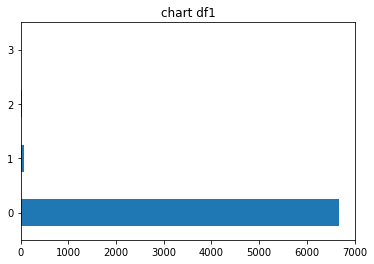

In [9]:
from chaininglib.utils.dfops import get_rank_diff
from chaininglib.ui.dfui import display_df

# For this case study, you need to run the previous case study first, because it generates a function we need here

# Use lexica and corpora from same period
base_lexicon1="mnwlex"
corpus_to_search1="gysseling"

base_lexicon2="lexicon_service_db"
corpus_to_search1="zeebrieven"

lemma="het"

# build frequency tables of two corpora

df_frequency_list1 = get_frequency_list_given_a_corpus(base_lexicon1, lemma, corpus_to_search1)
# sort and display
df_top25_descending = df_frequency_list1.sort_values(ascending=False,by=['token count']).head(25)
df_top25_ascending =  df_frequency_list1.sort_values(ascending=True, by=['rank']).head(25)
display_df( df_top25_ascending )
print(type(df_top25_descending['token count']))
display_df( df_top25_descending['token count'], labels='chart df1', mode='chart' )

df_frequency_list2 = get_frequency_list_given_a_corpus(base_lexicon2, lemma, corpus_to_search2)
# sort and display
df_top25_descending = df_frequency_list2.sort_values(ascending=False,by=['token count']).head(25)
df_top25_ascending =  df_frequency_list2.sort_values(ascending=True, by=['rank']).head(25)
display_df( df_top25_ascending )
display_df( df_top25_descending['token count'], labels='chart df2', mode='chart' )


# TODO: lemmata tonen die in 1 of 2 ontbreken

# compute the rank diff of lemmata in frequency tables

# sort and display
df_rankdiffs = get_rank_diff(df_frequency_list1, df_frequency_list2)

display_df(df_rankdiffs.sort_values(by=['rank_diff']).head(25))

df_top25_descending = df_rankdiffs.sort_values(ascending=False, by=['rank_diff']).head(25)
display_df( df_top25_descending['rank_diff'], labels='chart large diff', mode='chart' )

df_top25_ascending = df_rankdiffs.sort_values(ascending=True, by=['rank_diff']).head(25)
display_df( df_top25_ascending['rank_diff'], labels='chart small diff', mode='chart' )

### Search corpus for wordforms of lemma not included in lexicon <a class="anchor" id="corpus-wordforms-not-lexicon"></a>

In [10]:
from chaininglib.search.LexiconQuery import *
from chaininglib.search.CorpusQuery import *
from chaininglib.ui.dfui import display_df

# Let's build a function to do the job:
# The function will require a lexicon name and a part-of-speech to limit the search to, and the name of a corpus to be searched.
# It will return a Pandas DataFrame associating lemmata to their paradigms ('known_wordforms' column) and
# missing wordforms found in the corpus ('unknown_wordforms' column).

def get_missing_wordforms(lexicon_lemmas, lexicon_wordforms, lexicon_pos, corpus_pos, corpus):    
    
    print('Finding missing wordforms in a lexicon can take a long time...');
    
    # LEXICON: 
    # get a lemmata list having a given part-of-speech
    
    lq = create_lexicon(lexicon_lemmas).pos(lexicon_pos).search()
    df_lexicon = lq.kwic()
    
    # Put the results into an array, so we can loop through the list of lemmata
    lexicon_lemmata_arr = [w.lower() for w in df_lexicon["wordform"]]
    
    # Test array, instead of querying Molex
    #lexicon_lemmata_arr = ["denken", "doen", "hebben", "maken"]
    
    # Prepare the output:
    # instantiate a DataFrame for storing lemmata and mssing wordforms
    df_enriched_lexicon = pd.DataFrame(index=lexicon_lemmata_arr, columns=['lemma', 'pos', 'known_wordforms', 'unknown_wordforms'])
    df_enriched_lexicon.index.name = 'lemmata'
    
    # CORPUS: 
    # loop through the lemmata list, query the corpus for each lemma, 
    # and compute paradigms differences between both

    
    # loop through the lemmata list
    # and query the corpus for occurances of the lemmata
    
    # It's a good idea to work with more than one lemma at the time (speed)!
    nr_of_lemmata_to_query_atonce = 100
    
    for i in range(0, len(lexicon_lemmata_arr), nr_of_lemmata_to_query_atonce):
        
        # slice to small array of lemmata to query at once
        small_lemmata_arr = lexicon_lemmata_arr[i : i+nr_of_lemmata_to_query_atonce]
        
        # join set of lemmata to send them in a query all at once
        # beware: single quotes need escaping
        lemmata_list = "|".join(small_lemmata_arr).replace("'", "\\\\'")
        print(lemmata_list)
        cq = create_corpus(corpus).pattern(r'[lemma="' + lemmata_list + r'" & pos="'+corpus_pos+'"]').search()
        df_corpus = cq.kwic()
        
        # if the corpus gave results,
        # query the lexicon for the same lemmata
        # and compare the paradigms!
        
        if (len(df_corpus)>0):
            small_lemmata_set = set(small_lemmata_arr)
            for one_lemma in small_lemmata_set: 
                print(one_lemma)
                # look up the known wordforms in the lexicon
                ql = create_lexicon(lexicon_wordforms).lemma(one_lemma).search()
                df_known_wordforms = ql.kwic()
                
                # we have a lexicon paradigm to compare, do the job now
                if (len(df_known_wordforms) != 0):
                    
                    # gather the lexicon wordforms in a set
                    known_wordforms = set( df_known_wordforms['wordform'].str.lower() )
                    
                    # gather the corpus wordforms (of the same lemma) in a set too
                    corpus_lemma_filter = (df_corpus['lemma 0'] == one_lemma)
                    corpus_wordforms = set( (df_corpus[ corpus_lemma_filter ])['word 0'].str.lower() )
                    
                    # Now compute the differences:
                    # gather in a set all the corpus wordforms that cannot be found in the lexicon wordforms 
                    unknown_wordforms = corpus_wordforms.difference(known_wordforms)

                    # If we found some missing wordforms, add the results to the output!
                    
                    if (len(unknown_wordforms) !=0):                        
                        # The index of our results will be a key consisting of lemma + part-of-speech
                        # Part-of-speech is needed to distinguish homonyms with different grammatical categories.
                        # Of course, we need to take glosses into account too to do a truely correct job
                        # But we didn't do it here
                        key = one_lemma + lexicon_pos
                        df_enriched_lexicon.at[key, 'lemma'] = one_lemma
                        df_enriched_lexicon.at[key, 'pos'] = lexicon_pos
                        df_enriched_lexicon.at[key, 'known_wordforms'] = known_wordforms
                        df_enriched_lexicon.at[key, 'unknown_wordforms'] = unknown_wordforms
                
    # return non-empty results, t.i. cases in which we found some wordforms
    return df_enriched_lexicon[ df_enriched_lexicon['unknown_wordforms'].notnull() ]


# Run the function!

lexicon_lemmas="molex"
lexicon_wordforms="lexicon_service_db"
corpus_to_search="zeebrieven"

lemma="boek"

df = get_missing_wordforms(lexicon_lemmas, lexicon_wordforms, "VERB", "VRB", corpus_to_search)

# After such a heavy process, it's a good idea to save the results

df.to_csv( "missing_wordforms.csv", index=False)

display_df(df)


Finding missing wordforms in a lexicon can take a long time...
                                                                    

KeyError: 'wordform'

## Treebanks

### Treebank search <a class="anchor" id="treebank-search"></a>

In [11]:
from chaininglib.search.TreebankQuery import *


print ("search...")

tbq = create_treebank().pattern("xquery //node[@cat='pp' and node[@cat='ap' and node[@cat='np']]]").search()

print ("get XML...")

xml = tbq.xml()
print(xml)

print ("get trees and their string representations...")

trees = tbq.trees()

for tree in trees:
    display(tree.toString())

df = tbq.kwic()
    
display(df)

search...
get XML...                                                          
<node begin="3" cat="pp" end="7" id="7" rel="mod">
  <node begin="3" end="4" id="8" lcat="VZ(init)" lemma="van" pos="T701" postag="VZ(init)" pt="vz" rel="hd" root="van" vztype="init" word="van"/>
  <node begin="4" cat="ap" end="7" id="9" rel="obj1">
    <node begin="4" cat="np" end="6" id="10" rel="me">
      <node begin="4" end="5" id="11" lcat="TW(hoofd,prenom,stan)" lemma="drieduizend" naamval="stan" numtype="hoofd" pos="T401" positie="prenom" postag="TW(hoofd,prenom,stan)" pt="tw" rel="det" root="drieduizend" word="drieduizend"/>
      <node begin="5" end="6" genus="onz" getal="ev" graad="basis" id="12" lcat="N(soort,ev,basis,onz,stan)" lemma="jaar" naamval="stan" ntype="soort" pos="T102" postag="N(soort,ev,basis,onz,stan)" pt="n" rel="hd" root="jaar" word="jaar"/>
    </node>
    <node begin="6" buiging="zonder" end="7" graad="basis" id="13" lcat="ADJ(vrij,basis,zonder)" lemma="oud" pos="T227" positie="

' [ van  [  [ drieduizend jaar ]/np oud ]/ap ]/pp'

' [ van  [  [  [ een paar ]/np huizen ]/np verder ]/ap ]/pp'

' [ van  [  [ zeven centimeter ]/np dik ]/ap ]/pp'

' [ van  [  [ dertig jaar ]/np oud ]/ap ]/pp'

' [ met  [  [ je mond ]/np vol ]/ap ]/pp'

" [ van  [  [ 's morgens ]/np vroeg  [ tot  [  [ 's avonds ]/np laat ]/ap ]/pp ]/ap ]/pp"

" [ tot  [  [ 's avonds ]/np laat ]/ap ]/pp"

' [ met  [  [ je ogen ]/np dicht ]/ap ]/pp'

' [  [  [  [ een paar ]/np metertjes ]/np verder ]/ap naar voren ]/pp'

' [ van  [  [ vijftien jaar ]/np oud ]/ap ]/pp'

' [ van  [  [ zevenhonderd meter ]/np lang ]/ap ]/pp'

" [ tot  [  [ 's avonds ]/np laat ]/ap ]/pp"

' [ van  [  [  [ vijftig zestig zeventig tachtig ]/list jaar ]/np oud ]/ap ]/pp'

' [ van  [  [ een beetje ]/np blasé ]/ap ]/pp'

' [ van  [  [  [ elf dertien en veertien ]/conj jaar ]/np oud ]/ap ]/pp'

' [ van  [  [ meter  [  [ een of ]/mwu dertig ]/detp ]/np hoog ]/ap ]/pp'

,lemma 0,pos 0,wordform 0,lemma 1,pos 1,wordform 1,lemma 2,pos 2,wordform 2,lemma 3,...,wordform 4,lemma 5,pos 5,wordform 5,lemma 6,pos 6,wordform 6,lemma 7,pos 7,wordform 7
0,van,VZ(init),van,drieduizend,"TW(hoofd,prenom,stan)",drieduizend,jaar,"N(soort,ev,basis,onz,stan)",jaar,oud,...,,,,,,,,,,
1,van,VZ(init),van,een,"LID(onbep,stan,agr)",een,paar,"N(soort,ev,basis,onz,stan)",paar,huis,...,verder,,,,,,,,,
2,van,VZ(init),van,zeven,"TW(hoofd,prenom,stan)",zeven,centimeter,"N(soort,ev,basis,zijd,stan)",centimeter,dik,...,,,,,,,,,,
3,van,VZ(init),van,dertig,"TW(hoofd,prenom,stan)",dertig,jaar,"N(soort,ev,basis,onz,stan)",jaar,oud,...,,,,,,,,,,
4,met,VZ(init),met,je,"VNW(bez,det,stan,red,2v,ev,prenom,zonder,agr)",je,mond,"N(soort,ev,basis,zijd,stan)",mond,vol,...,,,,,,,,,,
5,van,VZ(init),van,de,"LID(bep,gen,evmo)",'s,morgen,"N(soort,ev,basis,gen)",morgens,vroeg,...,tot,de,"LID(bep,gen,evmo)",'s,avond,"N(soort,ev,basis,gen)",avonds,laat,"ADJ(vrij,basis,zonder)",laat
6,tot,VZ(init),tot,de,"LID(bep,gen,evmo)",'s,avond,"N(soort,ev,basis,gen)",avonds,laat,...,,,,,,,,,,
7,met,VZ(init),met,je,"VNW(bez,det,stan,red,2v,ev,prenom,zonder,agr)",je,oog,"N(soort,mv,basis)",ogen,dicht,...,,,,,,,,,,
8,een,"LID(onbep,stan,agr)",een,paar,"N(soort,ev,basis,onz,stan)",paar,meter,"N(soort,mv,dim)",metertjes,ver,...,naar,voren,BW(),voren,,,,,,
9,van,VZ(init),van,vijftien,"TW(hoofd,prenom,stan)",vijftien,jaar,"N(soort,ev,basis,onz,stan)",jaar,oud,...,,,,,,,,,,


### Which kind of nouns are used in a prepositional complement of the verb *geven* ? <a class="anchor" id="treebank-objects-geven"></a>

In [12]:
from chaininglib.search.TreebankQuery import *


print ("search...")

tbq = create_treebank().pattern(r'xquery //node[node[@rel="hd" and @pt="ww" and @root="geven"] and node[@rel="obj1" and @pt="n"]]').search()


print ("get list of nouns which are part of an PP, as argument of predicate 'geven'...")

trees = tbq.trees()

list_of_nouns = []
for tree in trees:
    nouns = tree.extract(['pp', 'np'])
    list_of_nouns = list_of_nouns + nouns
    

display(list_of_nouns)
    
df = tbq.kwic(align_lemma='geven')
display(df)

search...
get list of nouns which are part of an PP, as argument of predicate 'geven'...


['een Miele',
 'de Davondsfonds-leden',
 'de -bestuursleden',
 'de ontwikkeling van lokale Nederlandstalige educatieve software',
 'de verdediging',
 'de glastelers',
 'haar woede',
 'één stuk',
 'de computer',
 'de kampen die  komen te in Amsterdam Groningen Rotterdam en Tilburg staan',
 'het jaar',
 'ene kamp',
 'veranderingen in de school',
 "'t conservatorium als basis"]

,left context,lemma 0,pos 0,wordform 0,right context
0,voorkeur,geven,"WW(inf,vrij,zonder)",geven,aan een Miele
1,ere,geven,"WW(inf,vrij,zonder)",geven,wie ere toekomt
2,hem gelijk,geven,"WW(inf,vrij,zonder)",geven,
3,u cijfers,geven,"WW(inf,vrij,zonder)",geven,hoe is de politieke voorkeur van de Davondsfonds-leden en de -bestuursleden
4,mijn beesten eten,geven,"WW(inf,nom,zonder,zonder-n)",geven,
5,we,geven,"WW(pv,tgw,mv)",geven,prijzen voor de ontwikkeling van lokale Nederlandstalige educatieve software
6,we nu prijzen,geven,"WW(pv,tgw,mv)",geven,
7,elkaar verrijking,geven,"WW(inf,vrij,zonder)",geven,
8,Gods liefde gestalte,geven,"WW(inf,vrij,zonder)",geven,
9,kwaadheid woorden,geven,"WW(inf,vrij,zonder)",geven,zonder te in de verdediging gaan
